In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df =pd.read_csv(r"C:\Users\jongb\Downloads\archive\PJME_hourly.csv")

df = df.set_index('Datetime')

df.index = pd.to_datetime(df.index)

In [8]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [31]:
df.head(1)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False


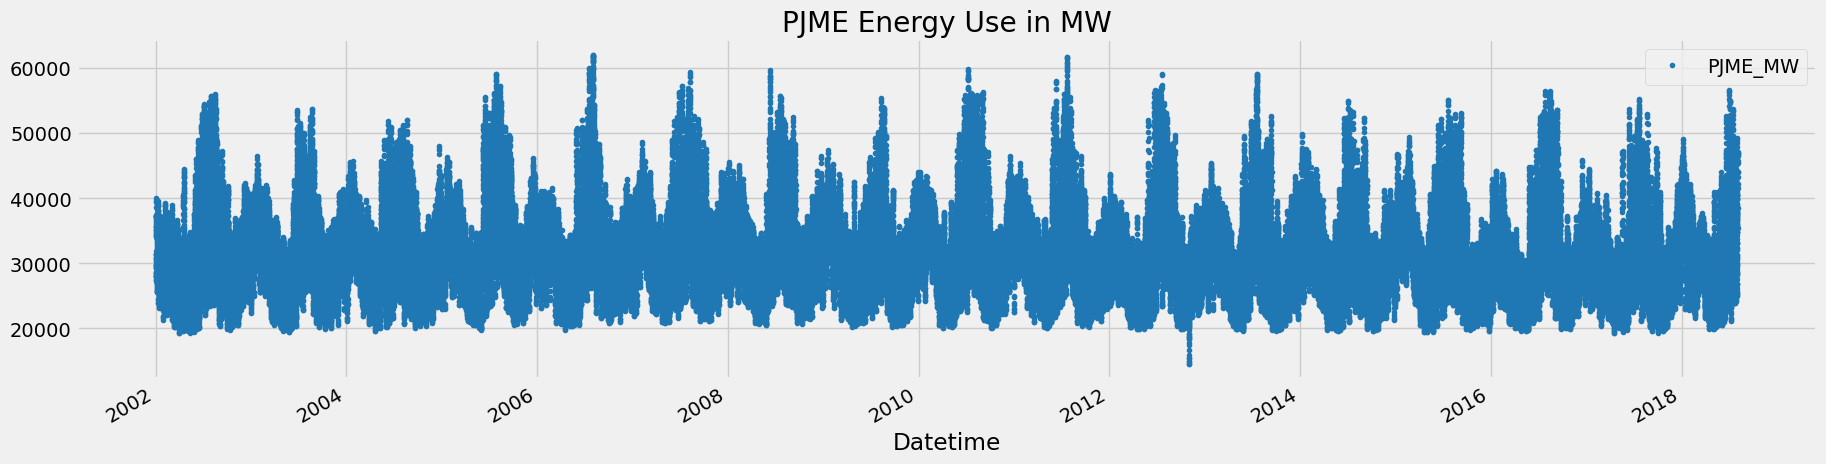

In [5]:
df.plot(style='.',
        figsize=(20, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [6]:
df.isna().sum()

PJME_MW    0
dtype: int64

In [7]:
### Outlier Analysis and removal

<AxesSubplot:ylabel='Frequency'>

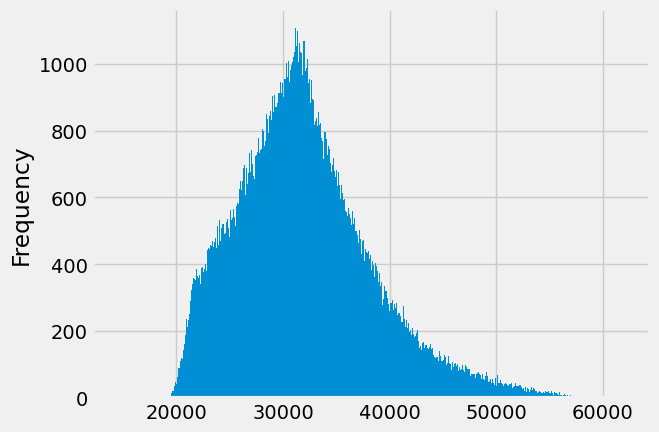

In [9]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

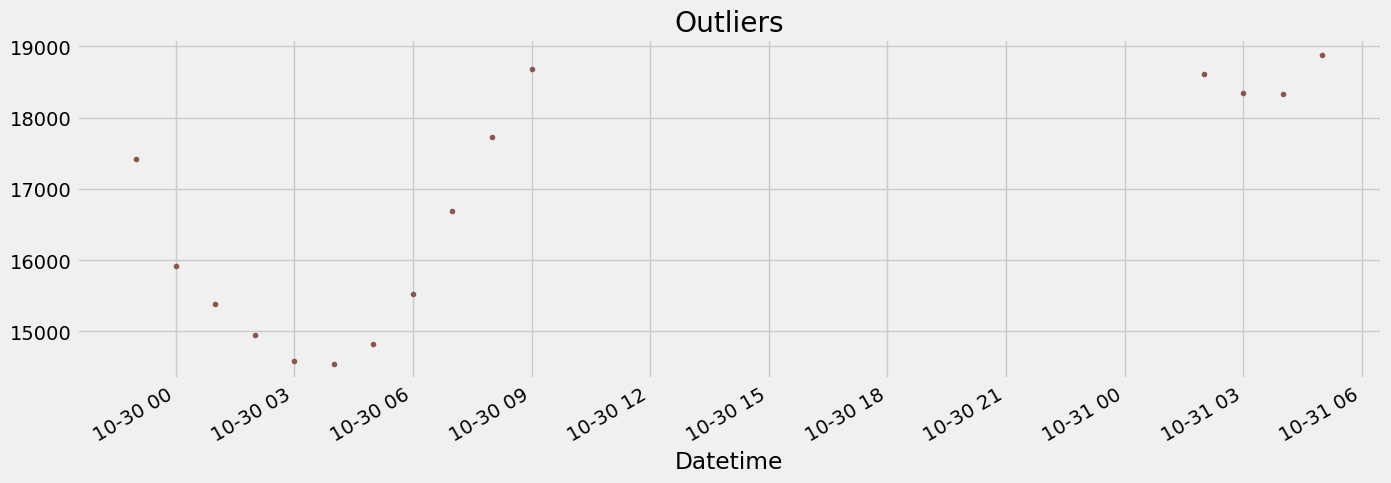

In [10]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [11]:
df = df.query('PJME_MW > 19_000').copy()

In [ ]:
### Train and Test datesets

#train = df.loc[df.index < '01-01-2015']
#test = df.loc[df.index >= '01-01-2015']

#fig, ax = plt.subplots(figsize=(15, 5))
#train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
#test.plot(ax=ax, label='Test Set')
#ax.axvline('01-01-2015', color='black', ls='--')
#ax.legend(['Training Set', 'Test Set'])
#plt.show()

In [14]:
### Cross-Validation

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

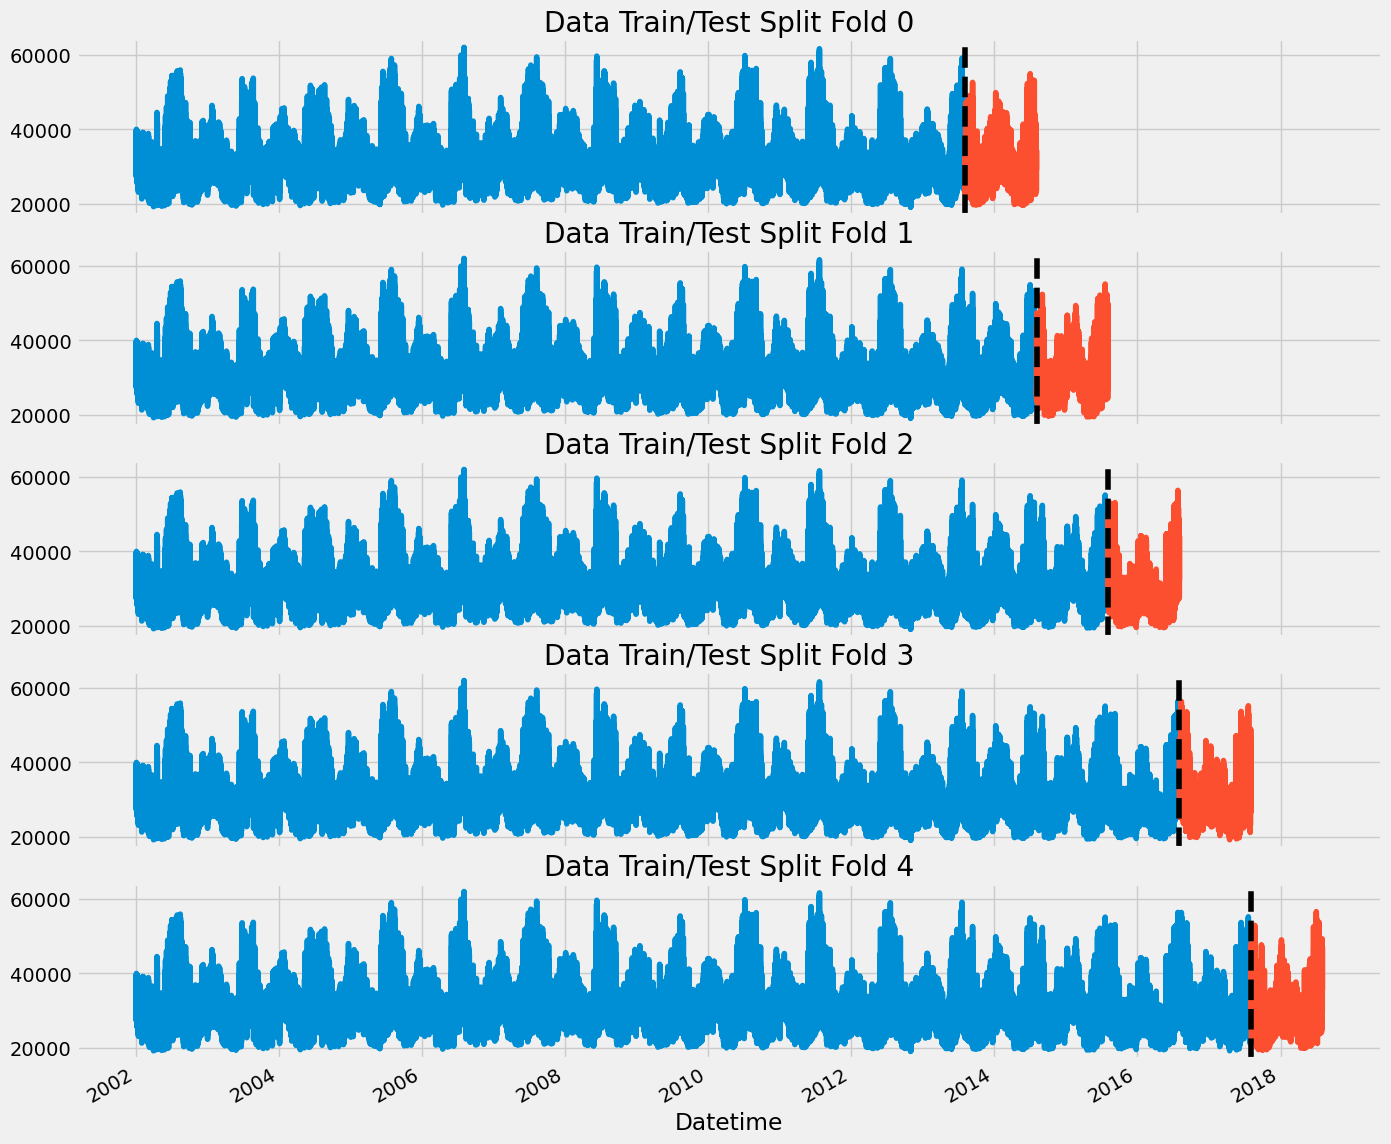

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

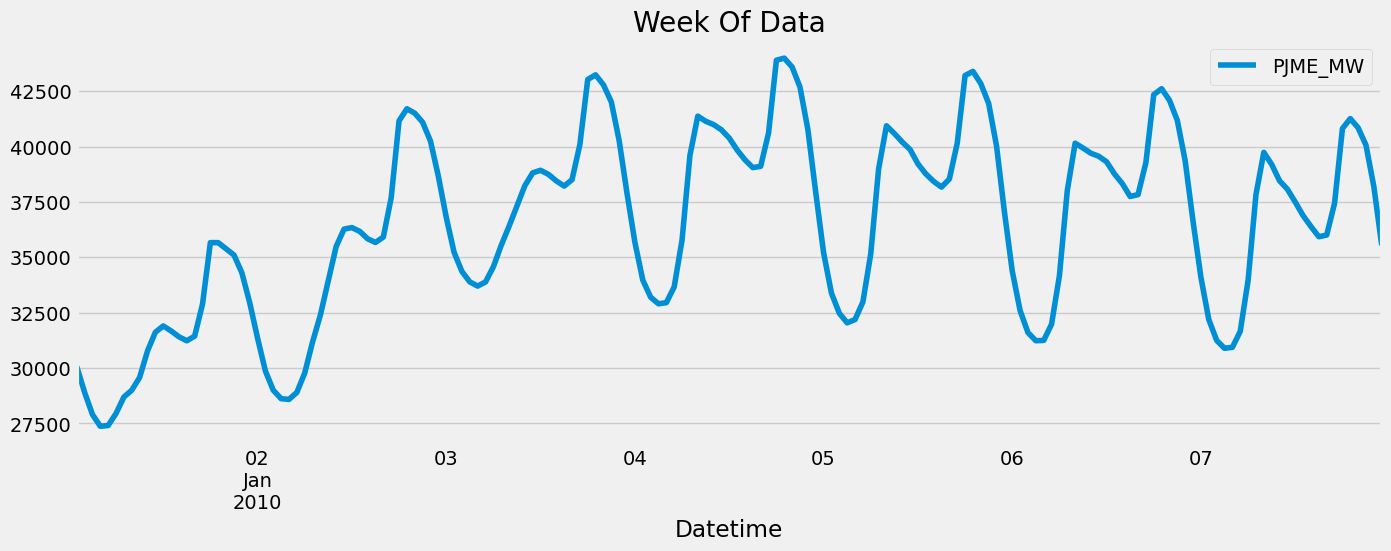

In [16]:
##check a week data
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [17]:
### Feature Creation

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [18]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [20]:
df = add_lags(df)

In [22]:
df.tail(10)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 15:00:00,47154.0,15,3,3,8,2018,214,2,31,46462.0,42631.0,41414.0
2018-08-02 16:00:00,46989.0,16,3,3,8,2018,214,2,31,47318.0,43575.0,41956.0
2018-08-02 17:00:00,46816.0,17,3,3,8,2018,214,2,31,47490.0,44267.0,41920.0
2018-08-02 18:00:00,46760.0,18,3,3,8,2018,214,2,31,46436.0,44460.0,41430.0
2018-08-02 19:00:00,45641.0,19,3,3,8,2018,214,2,31,44429.0,43375.0,39990.0
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0


In [ ]:
### Visualize our Feature / Target Relationship

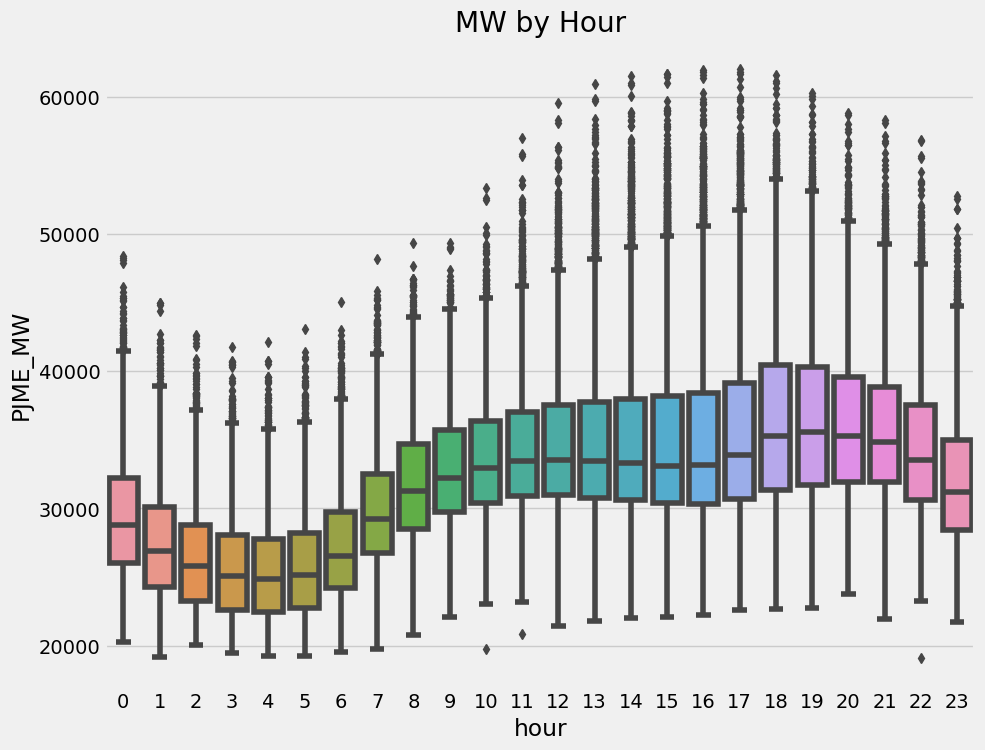

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='hour', y='PJME_MW')

ax.set_title('MW by Hour')

plt.show()

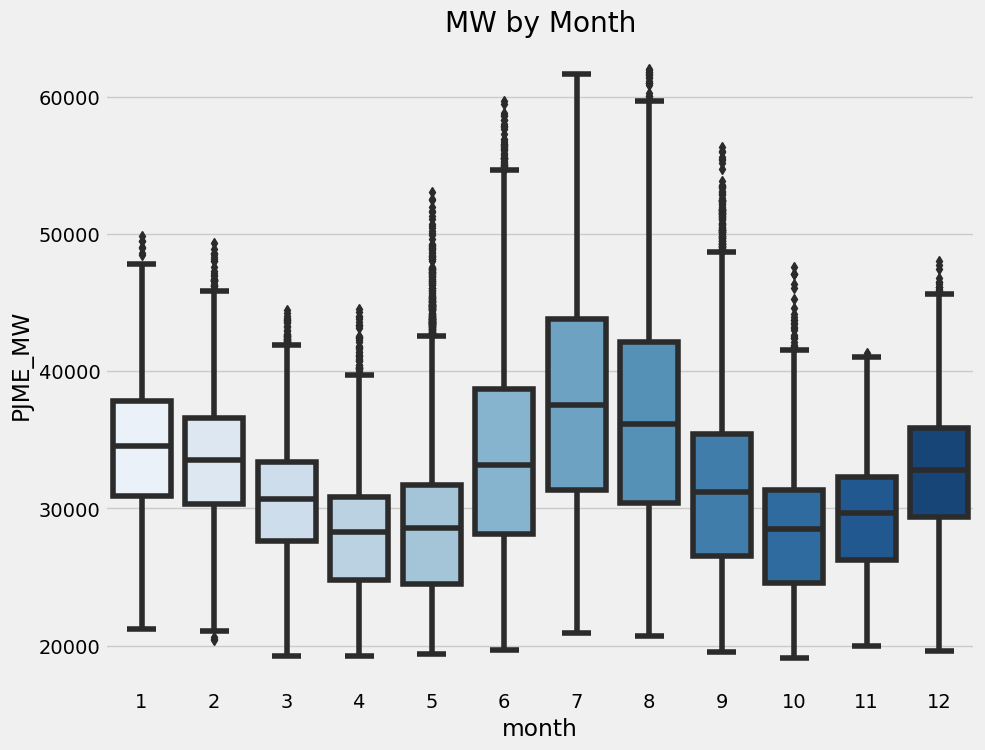

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [ ]:
### Train model Using Cross Validation

In [25]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    
    preds.append(y_pred)
    
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    scores.append(score)

[19:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[450]	validation_0-rmse:3356.42691	validation_1-rmse:3762.64793
[19:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.56552	validation_1-rmse:5655.33259
[300]	validation_0-rmse:3904.98895	validation_1-rmse:3931.65967
[4

In [26]:
### Score
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3753.5994
Fold scores:[3757.485267269142, 3422.628654218696, 3473.0621874794947, 4115.966281700851, 3998.8545666889618]


In [ ]:
### Predicting the Future

In [ ]:
    #Retrain on all data

In [27]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[19:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [28]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [29]:
### Create future dataframe

future = pd.date_range('2018-08-03','2019-08-01', freq='1h')

future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True

df['isFuture'] = False

df_and_future = pd.concat([df, future_df])

df_and_future = create_features(df_and_future)

df_and_future = add_lags(df_and_future)

In [33]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
### Predict the future

In [34]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [35]:
future_w_features.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True,42224.484375
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True,41445.375000
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True,40743.679688
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True,38417.695312
2019-08-01 00:00:00,NaN,0,3,3,8,2019,213,1,31,37158.0,31646.0,31470.0,True,32234.416016


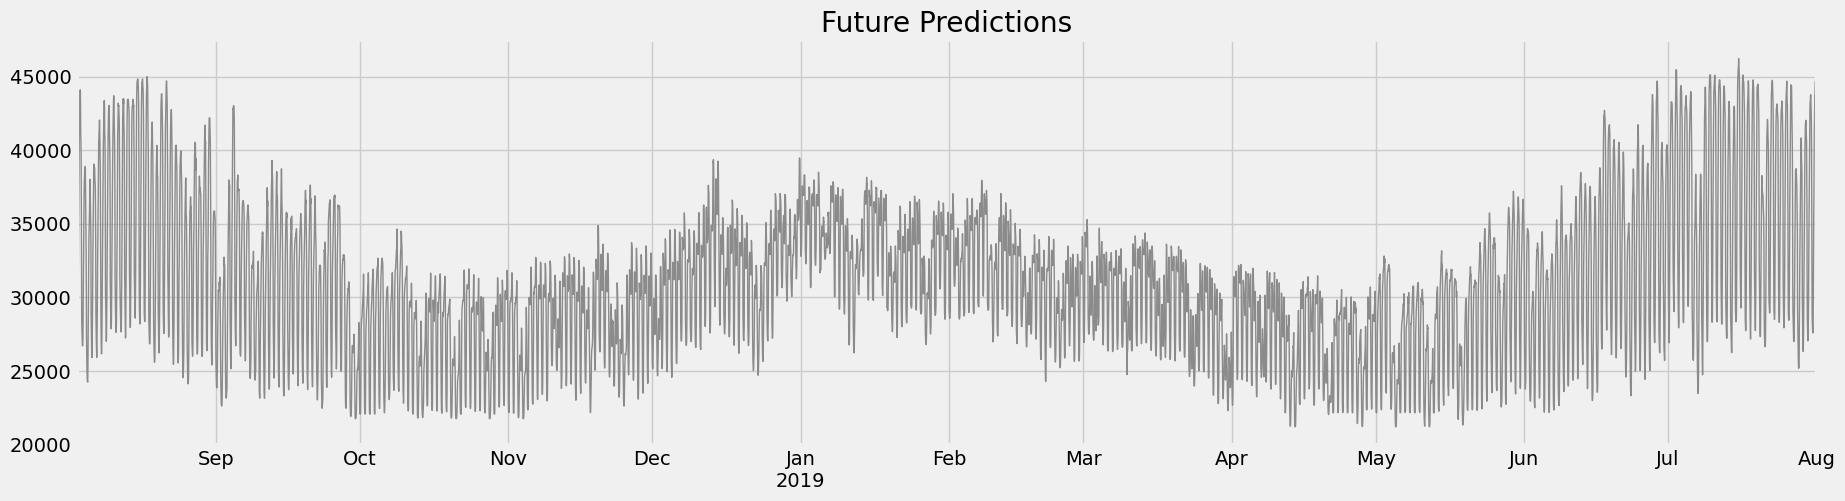

In [36]:
future_w_features['pred'].plot(figsize=(20, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [ ]:
###  Saving Model For later

In [37]:
  ## Save model
reg.save_model('model.json')

In [40]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

<AxesSubplot:title={'center':'Future Predictions'}>

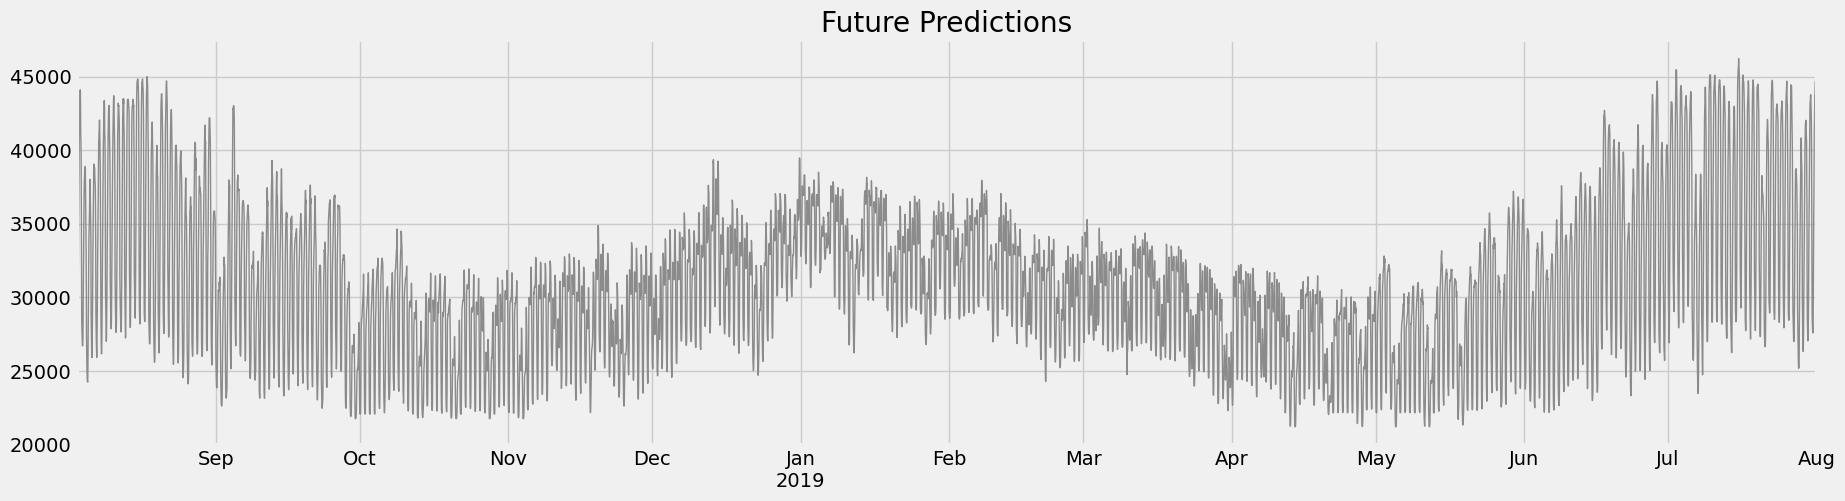

In [41]:
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(20, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')